In [181]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM,Flatten, RepeatVector
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

2.7.0


In [182]:
df = pd.read_csv('SD_dataset_FINAL.csv')
df.head()

,Sentence,Label,Category
0,"For a woman, that is good",1,1
1,Just dress sexy and you will sign any contract.,1,1
2,Are you having period ?,1,1
3,Stop being bitchy,1,1
4,I leave early because of her children instead ...,1,1


In [183]:
nRow, nCol = df.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 1142 rows and 3 columns


In [184]:
decision = {0: 'neutral', 1: 'sexist'}
def decision_convert(x):
    return decision[x]

df['Category'] = df['Category'].apply(lambda x: decision_convert(x))
df

,Sentence,Label,Category
0,"For a woman, that is good",1,sexist
1,Just dress sexy and you will sign any contract.,1,sexist
2,Are you having period ?,1,sexist
3,Stop being bitchy,1,sexist
4,I leave early because of her children instead ...,1,sexist
...,...,...,...
1137,Women Do six percent of the Work but get all o...,1,sexist
1138,My Big Bang Theory Is: Women Don’t Like Physics.,1,sexist
1139,this area of study was invented and built by men,1,sexist
1140,Katie and several other women scientists on ou...,0,neutral


In [185]:
# Grouping data by label
df['Category'].value_counts()

sexist     627
neutral    515
Name: Category, dtype: int64

In [186]:
neither, sexist = np.bincount(df['Label'])
total = sexist + neither
print('Examples:\n    Total: {}\n    Sexist: {} ({:.2f}% of total)\n'.format(
    total, sexist, 100 * sexist / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 1142
    Sexist: 627 (54.90% of total)

Examples:
    Total: 1142
    Neither: 515 (45.10% of total)



In [187]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.Label.values,
    test_size=0.20,
    random_state=12,
    stratify=df.Label.values,    
)

In [188]:
 X_train, X_val, y_train, y_val = train_test_split(
     df.loc[X_train_].index.values,
     df.loc[X_train_].Label.values,
     test_size=0.20,
     random_state=12,
     stratify=df.loc[X_train_].Label.values,  
 )

In [189]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train_, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [190]:
df.groupby(['Category', 'Label','data_type']).count()

Sentence
Category Label data_type          
neutral  0     test            103
               train           329
               val              83
sexist   1     test            126
               train           401
               val             100

In [191]:
df

,Sentence,Label,Category,data_type
0,"For a woman, that is good",1,sexist,test
1,Just dress sexy and you will sign any contract.,1,sexist,test
2,Are you having period ?,1,sexist,val
3,Stop being bitchy,1,sexist,val
4,I leave early because of her children instead ...,1,sexist,train
...,...,...,...,...
1137,Women Do six percent of the Work but get all o...,1,sexist,train
1138,My Big Bang Theory Is: Women Don’t Like Physics.,1,sexist,train
1139,this area of study was invented and built by men,1,sexist,train
1140,Katie and several other women scientists on ou...,0,neutral,train


In [192]:
df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

df_train.head()

,Sentence,Label,Category,data_type
4,I leave early because of her children instead ...,1,sexist,train
5,You can thank the quotas,1,sexist,train
7,That is a woman thing,1,sexist,train
8,You are too emotional,1,sexist,train
9,You have to wear a dress,1,sexist,train


In [193]:
df_train_plus_val = pd.concat([df_train,df_val], axis=0)
df_train_plus_val.head()

,Sentence,Label,Category,data_type
4,I leave early because of her children instead ...,1,sexist,train
5,You can thank the quotas,1,sexist,train
7,That is a woman thing,1,sexist,train
8,You are too emotional,1,sexist,train
9,You have to wear a dress,1,sexist,train


In [194]:
x = df_train_plus_val.Sentence.values
y = df_train_plus_val.Label.values

In [195]:
max_features = 20000
max_text_length = 512

In [196]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [197]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [198]:
x_test_tokenized = x_tokenizer.texts_to_sequences(df_test.Sentence.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [242]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6b.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [243]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [244]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(df_test.Label, num_classes=3)
y_train_plus_val

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# Building 1 D CNN Model

In [572]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Bidirectional(LSTM(64,return_sequences=True)))

model.add(Dropout(0.5))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
#model.add(GlobalMaxPooling1D())

model.add(Bidirectional(LSTM(32,return_sequences=False)))

model.add(Dense(16, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.5))

#model.add(GlobalMaxPooling1D())

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_93 (Embedding)    (None, None, 100)         2000000   
                                                                 
 bidirectional_98 (Bidirecti  (None, None, 128)        84480     
 onal)                                                           
                                                                 
 dropout_174 (Dropout)       (None, None, 128)         0         
                                                                 
 conv1d_320 (Conv1D)         (None, None, 64)          16448     
                                                                 
 max_pooling1d_175 (MaxPooli  (None, None, 64)         0         
 ng1D)                                                           
                                                                 
 conv1d_321 (Conv1D)         (None, None, 64)        

In [573]:
model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [574]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 12, validation_split=0.2, epochs=15)

Epoch 1/15
61/61 [==============================] - 19s 222ms/step - loss: 0.8503 - accuracy: 0.5233 - val_loss: 0.7141 - val_accuracy: 0.5464
Epoch 2/15
61/61 [==============================] - 13s 208ms/step - loss: 0.7542 - accuracy: 0.5329 - val_loss: 0.6994 - val_accuracy: 0.5464
Epoch 3/15
61/61 [==============================] - 13s 211ms/step - loss: 0.7209 - accuracy: 0.5795 - val_loss: 0.6861 - val_accuracy: 0.6284
Epoch 4/15
61/61 [==============================] - 13s 209ms/step - loss: 0.6246 - accuracy: 0.6877 - val_loss: 0.5413 - val_accuracy: 0.7268
Epoch 5/15
61/61 [==============================] - 12s 202ms/step - loss: 0.5100 - accuracy: 0.7918 - val_loss: 0.5947 - val_accuracy: 0.7322
Epoch 6/15
61/61 [==============================] - 12s 205ms/step - loss: 0.4932 - accuracy: 0.8082 - val_loss: 0.4753 - val_accuracy: 0.7760
Epoch 7/15
61/61 [==============================] - 13s 212ms/step - loss: 0.4600 - accuracy: 0.8260 - val_loss: 0.5133 - val_accuracy: 0.7705

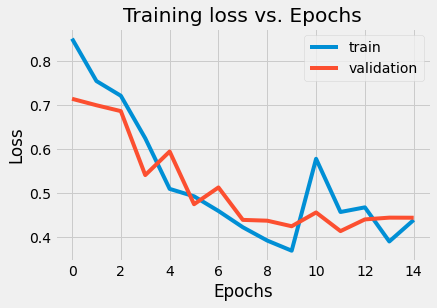

In [575]:
# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

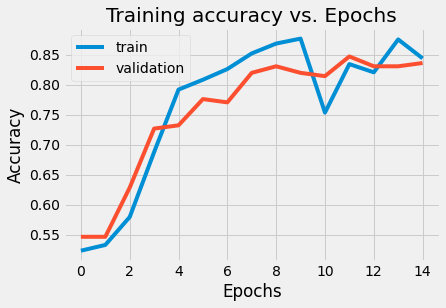

In [576]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

In [577]:
model.evaluate(x_test,y_test, batch_size = 64)

4/4 [==============================] - 1s 142ms/step - loss: 0.4123 - accuracy: 0.8472


[0.41234371066093445, 0.847161591053009]

In [578]:
y_pred = model.predict(x_test)
y_pred

array([[8.62262845e-02, 9.12474573e-01, 1.29912654e-03],
       [9.87368599e-02, 9.00102735e-01, 1.16049894e-03],
       [7.48735294e-02, 9.23594832e-01, 1.53160177e-03],
       [7.03055710e-02, 9.28371727e-01, 1.32269796e-03],
       [5.83408296e-01, 4.14942473e-01, 1.64919603e-03],
       [7.70743638e-02, 9.21527743e-01, 1.39787619e-03],
       [5.85877597e-01, 4.12298560e-01, 1.82376173e-03],
       [7.96825647e-01, 2.00530678e-01, 2.64374004e-03],
       [8.04772824e-02, 9.18157995e-01, 1.36472518e-03],
       [6.88541770e-01, 3.09237152e-01, 2.22112914e-03],
       [7.76278079e-02, 9.20940936e-01, 1.43131462e-03],
       [6.96458444e-02, 9.28826034e-01, 1.52807450e-03],
       [8.89180005e-01, 1.06973939e-01, 3.84602812e-03],
       [8.95451546e-01, 1.00361802e-01, 4.18663863e-03],
       [8.87726307e-01, 1.08318694e-01, 3.95502802e-03],
       [7.58627579e-02, 9.22646821e-01, 1.49044662e-03],
       [7.23183826e-02, 9.26436067e-01, 1.24556082e-03],
       [4.06810313e-01, 5.91895

In [579]:
y_pred = np.array( [ np.argmax (y) for y in y_pred ] )

In [580]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [581]:
y_test_labels = df_test.Label

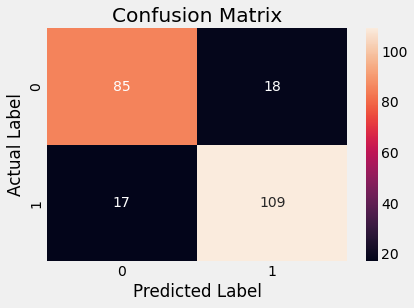

In [582]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test_labels, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

In [583]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       103
           1       0.86      0.87      0.86       126

    accuracy                           0.85       229
   macro avg       0.85      0.85      0.85       229
weighted avg       0.85      0.85      0.85       229

